### Climate Impacts (Flooding) on Real Estate Markets: A Causal Inference Framework 

#### (1) Retrieve Data

In [1214]:
import pandas as pd 
import numpy as np 
import glob
import duckdb
import geopandas as gpd 

build_tbls = '''
drop table if exists nfip_claims
;

create table nfip_claims as 
select  
    id,
    asOfDate, 
    dateOfLoss,
    policyCount as insuredUnits, 
    baseFloodElevation, 
    ratedFloodZone, 
    occupancyType, 
    originalConstructionDate, 
    originalNBDate, 
    coalesce(amountPaidOnBuildingClaim,0) +                  
    coalesce(amountPaidOnContentsClaim,0) +                  
    coalesce(amountPaidOnIncreasedCostOfComplianceClaim,0) as totalClaim, 
    coalesce(totalBuildingInsuranceCoverage,0) + 
    coalesce(totalContentsInsuranceCoverage,0) as totalCovered, 
    coalesce(buildingDamageAmount,0) + coalesce(contentsDamageAmount,0) as totalDamageLoss, 
    buildingDeductibleCode, 
    contentsDeductibleCode,
    causeOfDamage, 
    buildingPropertyValue, 
    floodproofedIndicator, 
    floodEvent, 
    state, 
    reportedZipCode, 
    censusTract, 
    latitude, 
    longitude
from read_csv('{claims_data_path}', strict_mode=False)
;

drop table if exists nfip_claims_zip 
; 

create table nfip_claims_zip as 
select 
    reportedZipCode as zip, 
    state,
    floodEvent,
    dateOfLoss,
    count(id) as claimCounts,
    sum(insuredUnits) as policyCounts, 
    sum(totalClaim) as totalClaimZip, 
    sum(totalDamageLoss) as totalLossesZip
from nfip_claims
where dateOfLoss >= '2000-01-01'
group by 1,2,3,4
order by 5 desc
;

drop table if exists irs_zip
;

create table irs_zip as 
select 
    STATE, 
    ZIPCODE as zip, 
    AGI_STUB as adjGrossIncomeTaxBracket,
    N1 as numberTaxReturns, 
    MARS1 as singleStatusTotalReturns, 
    MARS2 as marriedStatusTotalReturns, 
    MARS4 as HoHTotalReturns, 
    N2 as totalIndividuals,
    VITA as volunteerAssistedReturns, 
    ELDERLY as elderlyReturns, 
    A00100 as adjustedGrossIncome, 
    A02650 as totalIncome, 
    N00200 as returnsTotalwSalariesWages, 
    N00300 as returnsTotalTaxableInterest, 
    A00300 as taxableInterestAmt,
    SCHF   as returnsTotalFarm, 
    A18450 as stateLocalSalesTaxTotal, 
    N18500 as realEstateTaxTotal, 
    N18800 as returnsTotalPersonalPropertyTax, 
    A18800 as propertyTaxAmtTotal, 
    N19300 as returnsTotalMortgageInterestPaid, 
    A19300 as mortgageInterestPaidTotal,
    N07225 as returnsDependentCareCredit, 
    A07225 as dependentCareCreditTotal, 
    N07230 as returnsEducationCredit, 
    A07230 as educationCreditTotal, 
    N85770 as returnsPremiumsCredit, ---aids in offsetting health insurance premiums
    A85770 as premiumsCreditTotal, 
from read_csv('{irs_data_path}', strict_mode=False)
;
    
drop table if exists zillow_home_prices
;

create table zillow_home_prices as 
select * 
from read_csv('{zillow_data_path}', strict_mode=False)
;

drop table if exists zip_geos
;

create table zip_geos as 
select * 
from {zip_geos_pd}
;

'''

read_jsons = [
    gpd.read_file(gj)[['ZCTA5CE10','geometry','ALAND10','AWATER10']] for gj in glob.glob('../datasets/State-zip-code-GeoJSON/*.json')
]
json_to_dfs = pd.concat(read_jsons)
json_to_dfs = json_to_dfs.rename(
                columns={
                    'ZCTA5CE10':'zip', 
                    'ALAND10':'landAreaTotal', 
                    'AWATER10':'waterAreaTotal'
            }
        )
json_to_dfs_no_geom = json_to_dfs.drop(columns=['geometry'])

con = duckdb.connect()
con.sql(
    build_tbls.format(
        claims_data_path='../datasets/Flood-insurance/FimaNfipClaims.csv',
        zillow_data_path='../datasets/Zillow-home-prices/zillow_realestate_ts_zip.csv', 
        irs_data_path='../datasets/Demographics/22irs.csv', 
        zip_geos_pd='json_to_dfs_no_geom'
    )
)

In [1215]:
def get_home_price_predictor_ts(region, con=con):
    df = con.sql(f"select * from zillow_home_prices where Metro = '{region}'").df()
    cols = ['RegionName', 'Metro','CountyName'] + [i for i in df.columns if len(i.split('-')) == 3]
    return_df = df[cols]
    return_df = return_df.rename(
        columns={
            'RegionName':'zip'
        }
    )
    zip_codes = return_df['zip'].unique()
    return return_df, zip_codes

def get_socioeconomic_confounders(zips, con=con): 
    zips_str = ','.join(zips)
    df = con.sql(f'select * from irs_zip where zip in ({zips_str})').df()
    return df, zips

def get_risk_variables(zips, con=con):
    zips_str = ','.join(zips)
    df = con.sql(
        f'''
         select * 
         from (select * from nfip_claims_zip where zip in ({zips_str})) nfip
         inner join zip_geos using (zip)
         order by dateOfLoss
         ;
         '''
    ).df()
    return df, zips

homeprices, zips = get_home_price_predictor_ts('Tampa-St. Petersburg-Clearwater, FL')
socioeconomic_tax_confounders, _ = get_socioeconomic_confounders(zips) 
risk_variables, _ = get_risk_variables(zips) 

In [1216]:
homeprices.head(5)

,zip,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,...,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31
0,33647,"Tampa-St. Petersburg-Clearwater, FL",Hillsborough County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,483810.127481,485155.669900,486271.689919,485822.579104,484775.210949,483445.405248,482168.393955,480713.605853,479269.959046,478170.035884
1,33511,"Tampa-St. Petersburg-Clearwater, FL",Hillsborough County,100309.233899,100770.271200,101121.373059,101820.793348,102076.725550,102278.773740,102500.099390,...,375597.330402,376067.491270,375800.276357,374943.956354,374585.513032,374585.620310,374432.226925,373223.704226,371195.054438,369420.756428
2,33578,"Tampa-St. Petersburg-Clearwater, FL",Hillsborough County,97976.492139,97967.320636,97932.591151,97915.831025,97689.020858,97656.591841,97760.290967,...,358784.829431,359355.977366,359243.275153,358347.572532,357180.875603,356000.306844,354747.141438,353214.252652,351395.276299,349637.123024
3,33612,"Tampa-St. Petersburg-Clearwater, FL",Hillsborough County,62633.334541,62878.364854,63178.339938,63849.665889,64503.145084,65078.919190,65616.670246,...,290846.645433,292118.977784,292595.965638,292192.238809,291516.289269,291219.237397,290931.044591,290458.572034,289543.342017,289030.698168
4,33615,"Tampa-St. Petersburg-Clearwater, FL",Hillsborough County,83464.261551,83771.315276,84012.841871,84552.958100,84939.300423,85325.894524,85771.398514,...,362676.190546,364055.762147,365170.728148,365739.385797,366042.906580,366254.771347,366359.912955,366003.562011,365045.642702,364116.559577


In [1217]:
socioeconomic_tax_confounders.head(5)

,STATE,zip,adjGrossIncomeTaxBracket,numberTaxReturns,singleStatusTotalReturns,marriedStatusTotalReturns,HoHTotalReturns,totalIndividuals,volunteerAssistedReturns,elderlyReturns,...,returnsTotalPersonalPropertyTax,propertyTaxAmtTotal,returnsTotalMortgageInterestPaid,mortgageInterestPaidTotal,returnsDependentCareCredit,dependentCareCreditTotal,returnsEducationCredit,educationCreditTotal,returnsPremiumsCredit,premiumsCreditTotal
0,FL,33510,1,4470.0,2920.0,410.0,1060.0,6580.0,30.0,810.0,...,0.0,0.0,0.0,0.0,350.0,98.0,170.0,73.0,700.0,4670.0
1,FL,33510,2,4290.0,2430.0,630.0,1100.0,7290.0,30.0,620.0,...,50.0,71.0,80.0,606.0,1340.0,1640.0,310.0,321.0,590.0,3851.0
2,FL,33510,3,2410.0,1240.0,630.0,430.0,4250.0,20.0,560.0,...,30.0,32.0,80.0,600.0,720.0,1532.0,120.0,142.0,160.0,1014.0
3,FL,33510,4,1400.0,510.0,690.0,170.0,2840.0,0.0,390.0,...,40.0,46.0,80.0,696.0,440.0,1051.0,70.0,82.0,70.0,426.0
4,FL,33510,5,1800.0,380.0,1300.0,110.0,4230.0,0.0,550.0,...,60.0,32.0,130.0,1178.0,650.0,1697.0,80.0,100.0,30.0,158.0


In [1218]:
risk_variables.head(5)

,zip,state,floodEvent,dateOfLoss,claimCounts,policyCounts,totalClaimZip,totalLossesZip,landAreaTotal,waterAreaTotal
0,33616,FL,None,2000-01-01,1,1.0,0.0,0.0,9844232,2113032
1,33549,FL,None,2000-01-25,1,1.0,0.0,0.0,30420933,3133397
2,33572,FL,None,2000-02-28,1,1.0,0.0,0.0,40777733,7541019
3,34691,FL,None,2000-03-30,1,1.0,0.0,0.0,21315991,29672022
4,34690,FL,None,2000-04-20,1,1.0,0.0,0.0,9717288,377079


In [1219]:
con.sql('''select distinct Metro from zillow_home_prices where Metro ilike '%tampa%';''')#.df()

┌─────────────────────────────────────┐
│                Metro                │
│               varchar               │
├─────────────────────────────────────┤
│ Tampa-St. Petersburg-Clearwater, FL │
└─────────────────────────────────────┘

#### (2) Analyze Risk Factors

EDA + risk scoring

In [1221]:
risk_variables['floodEvent'].unique()

array([None, 'Hurricane Gordon', 'Flooding', 'Tropical Storm Allison',
       'Tropical Storm Barry', 'Torrential rain',
       'Tropical Storm Isidore', 'Hurricane Charley', 'Hurricane Frances',
       'Hurricane Ivan', 'Hurricane Jeanne', 'Hurricane Dennis',
       'Hurricane Katrina', 'Hurricane Wilma', 'Tropical Storm Alberto',
       'Tropical Storm Fay', 'Hurricane Ike', 'Low pressure system',
       'Tropical Storm Debby', 'Hurricane Isaac', 'Mid-spring storms',
       'Hurricane Hermine', 'Hurricane Matthew', 'Hurricane Irma',
       'Hurricane Michael', 'Hurricane Sally', 'Hurricane Eta',
       'Tropical Storm Claudette', 'Hurricane Elsa',
       'Tropical Storm Fred', 'Tropical Storm Nicholas', 'Hurricane Ian',
       'Hurricane Nicole', 'April Florida Flooding', 'Hurricane Idalia',
       "December Nor'easter", 'June South Florida Flooding',
       'Hurricane Debby', 'Hurricane Francine', 'Hurricane Helene',
       'Hurricane Milton'], dtype=object)

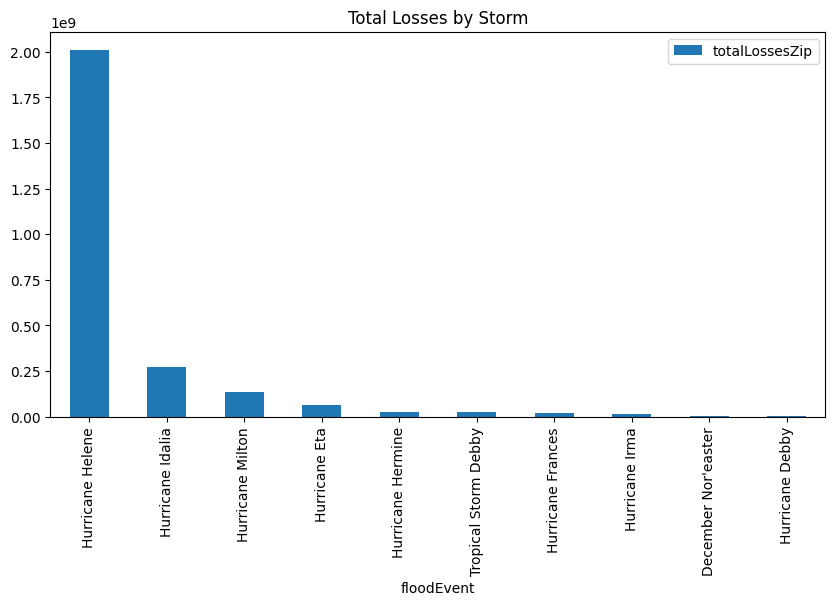

In [1222]:
import matplotlib.pyplot as plt
risk_variables\
    .groupby(['floodEvent'])[['claimCounts','totalClaimZip','totalLossesZip']]\
    .sum()\
    .sort_values(by='totalLossesZip', ascending=False)\
    .head(10)[['totalLossesZip']]\
    .plot(kind='bar', figsize=(10,5), title='Total Losses by Storm')
plt.show()

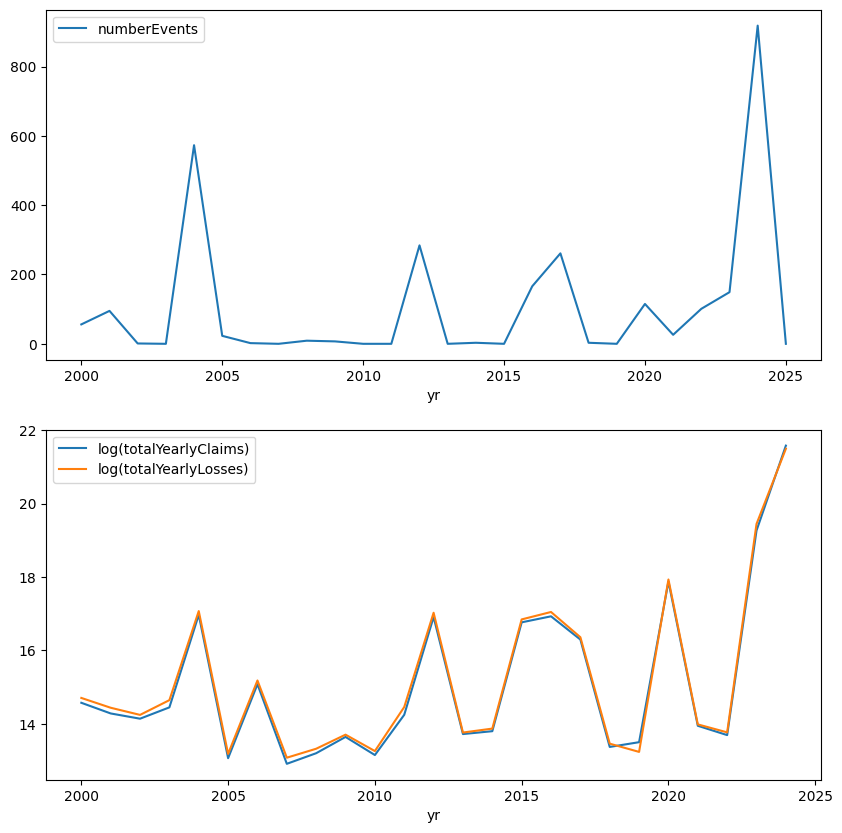

In [1223]:
risk_variables['yr'] = risk_variables['dateOfLoss'].dt.year 
risk_variables['waterAreaProp'] = risk_variables['waterAreaTotal'] / (risk_variables['landAreaTotal']+risk_variables['waterAreaTotal'])

yearly_stats = \
risk_variables.groupby(['yr']).agg(
    numberEvents=pd.NamedAgg(column='floodEvent',aggfunc='count'), 
    totalYearlyClaims=pd.NamedAgg(column='totalClaimZip',aggfunc='sum'), 
    totalYearlyLosses=pd.NamedAgg(column='totalLossesZip',aggfunc='sum')
)

yearly_stats['log(totalYearlyClaims)'] = np.log(yearly_stats['totalYearlyClaims']) 
yearly_stats['log(totalYearlyLosses)'] = np.log(yearly_stats['totalYearlyLosses']) 

fig, ax = plt.subplots(2,1,figsize=(10,10))
yearly_stats[['numberEvents']].plot(ax=ax[0])
yearly_stats[['log(totalYearlyClaims)','log(totalYearlyLosses)']].plot(ax=ax[1])
plt.show()

#risk_variables = risk_variables.drop(columns=['state'])

#zip_yearly.head(5)

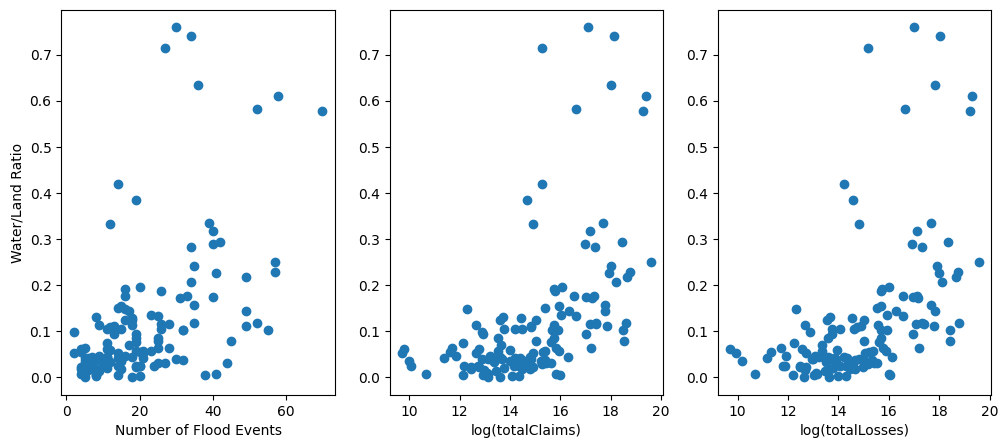

,numberEvents,waterAreaProp,log(totalClaims),log(totalLosses)
numberEvents,1.000000,0.509055,0.833974,0.844653
waterAreaProp,0.509055,1.000000,0.529077,0.520745
log(totalClaims),0.833974,0.529077,1.000000,0.992765
log(totalLosses),0.844653,0.520745,0.992765,1.000000


In [1224]:
zip_ = \
risk_variables.groupby(['zip']).agg(
    numberEvents=pd.NamedAgg(column='floodEvent',aggfunc='count'), 
    totalClaims=pd.NamedAgg(column='totalClaimZip',aggfunc='sum'), 
    totalLosses=pd.NamedAgg(column='totalLossesZip',aggfunc='sum'), 
    waterAreaProp=pd.NamedAgg(column='waterAreaProp',aggfunc='max')
)

zip_['log(totalClaims)'] = np.log(zip_['totalClaims']) 
zip_['log(totalLosses)'] = np.log(zip_['totalLosses']) 

fig,ax=plt.subplots(1,3,figsize=(12,5))
ax[0].scatter(x=zip_['numberEvents'],y=zip_['waterAreaProp'])
ax[0].set_xlabel('Number of Flood Events')
ax[0].set_ylabel('Water/Land Ratio')
ax[1].scatter(x=zip_['log(totalClaims)'],y=zip_['waterAreaProp'])
ax[1].set_xlabel('log(totalClaims)')
ax[2].scatter(x=zip_['log(totalLosses)'],y=zip_['waterAreaProp'])
ax[2].set_xlabel('log(totalLosses)')
plt.show()

zip_ = zip_.drop(columns=['totalClaims','totalLosses']) #use log-transformed vals

zip_.corr()

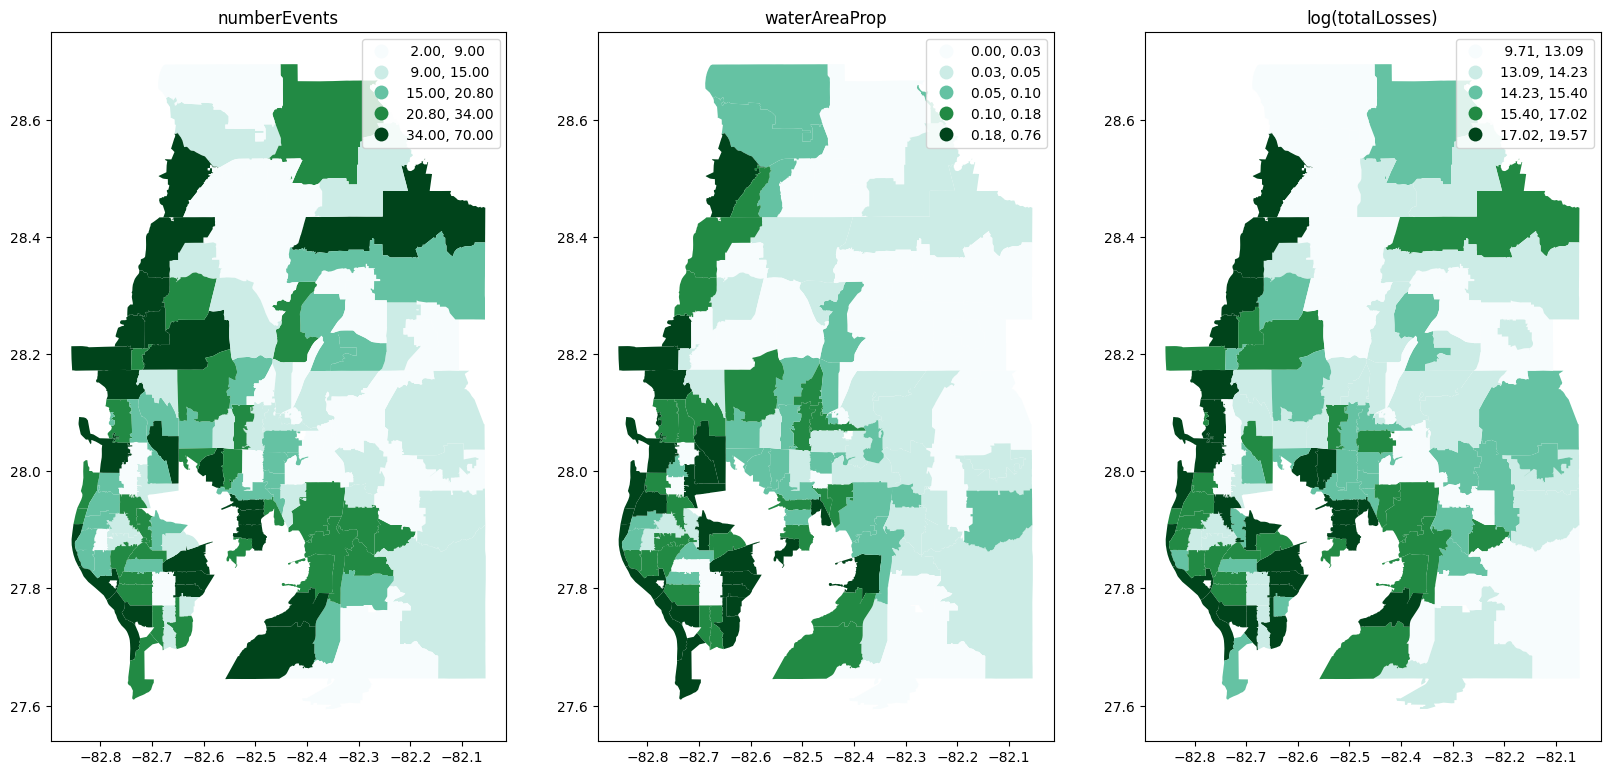

In [1225]:
zip_r = zip_.reset_index()
w_geom_zip = json_to_dfs[['zip','geometry']].merge(zip_r, how='inner', on='zip')
w_geom_zip = gpd.GeoDataFrame(w_geom_zip.drop(columns=['log(totalClaims)']))

rfs = ['numberEvents','waterAreaProp','log(totalLosses)']
fig,ax = plt.subplots(1,3,figsize=(20,20))
for _ax,col in zip(ax, rfs):
    w_geom_zip.plot(
         column=col, 
         legend=True, 
         markersize=0.01,
         figsize=(10,10),
         scheme='Quantiles', 
         legend_kwds={'loc': 'upper right'},
         cmap='BuGn',
         ax=_ax
    )
    _ax.set_title(col)

plt.show()


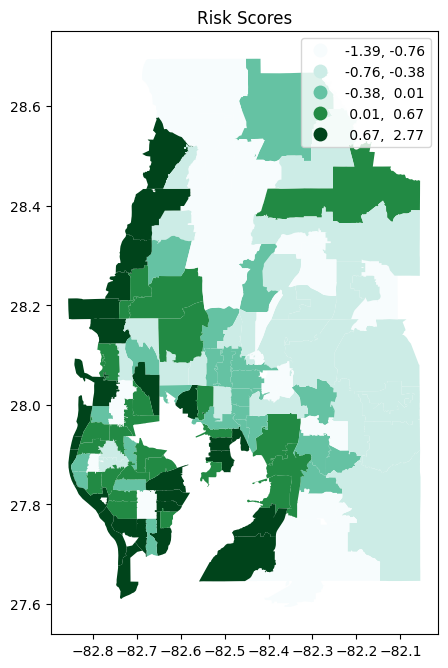

In [1226]:
from sklearn.preprocessing import StandardScaler

st = StandardScaler()
rf_matrix = w_geom_zip[rfs].values
weight = 1/len(rfs) 

rf_matrix_st = st.fit_transform(rf_matrix)
weights = (np.ones(len(rfs))*weight).reshape(-1,1)
risk_scores = rf_matrix_st @ weights

w_geom_zip['risk_score'] = risk_scores
w_geom_zip.plot(
         column='risk_score', 
         legend=True, 
         markersize=0.01,
         figsize=(5,8),
         scheme='Quantiles', 
         legend_kwds={'loc': 'upper right'},
         cmap='BuGn',
)
plt.title('Risk Scores')
plt.show()

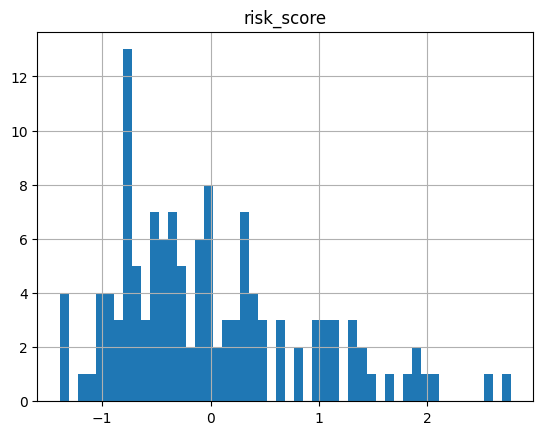

,geometry,numberEvents,waterAreaProp,log(totalLosses),risk_score,disaster_prone?
zip,,,,,,
34613,"POLYGON ((-82.51212 28.58471, -82.51072 28.584...",11,0.073768,12.251763,-0.777018,False
34609,"POLYGON ((-82.51562 28.51752, -82.5153 28.5179...",8,0.004621,12.191294,-1.005634,False
34601,"MULTIPOLYGON (((-82.42926 28.50132, -82.42871 ...",24,0.025931,14.509730,-0.225263,False
33603,"POLYGON ((-82.47715 28.00064, -82.47616 28.000...",19,0.022886,14.995523,-0.271906,False
33619,"POLYGON ((-82.35343 27.98152, -82.35122 27.981...",32,0.102294,15.924357,0.346960,True
...,...,...,...,...,...,...
34681,"POLYGON ((-82.7772 28.10076, -82.77724 28.1009...",16,0.192030,15.749695,0.142176,False
34695,"POLYGON ((-82.70073 28.03025, -82.70073 28.030...",19,0.384618,14.583933,0.445783,True
33756,"POLYGON ((-82.76256 27.95695, -82.76255 27.956...",20,0.195534,15.990098,0.280239,True


In [1227]:
w_geom_zip = w_geom_zip.set_index('zip')
w_geom_zip[['risk_score']].hist(bins=50)#.sort_values(by=['risk_score'])
plt.show()

w_geom_zip['disaster_prone?'] = w_geom_zip['risk_score'] > 0.25
w_geom_zip

In [1228]:
w_geom_zip['disaster_prone?'].value_counts()

disaster_prone?
False    87
True     42
Name: count, dtype: int64

#### (3) Analyze confounding socioeconomic factors

In [1230]:
num_rets_feats = [
    i for i in socioeconomic_tax_confounders.columns if 'return' in i.lower()
] 
num_rets_feats

['numberTaxReturns',
 'singleStatusTotalReturns',
 'marriedStatusTotalReturns',
 'HoHTotalReturns',
 'volunteerAssistedReturns',
 'elderlyReturns',
 'returnsTotalwSalariesWages',
 'returnsTotalTaxableInterest',
 'returnsTotalFarm',
 'returnsTotalPersonalPropertyTax',
 'returnsTotalMortgageInterestPaid',
 'returnsDependentCareCredit',
 'returnsEducationCredit',
 'returnsPremiumsCredit']

In [1231]:
piv=socioeconomic_tax_confounders.pivot(
    index='zip', columns='adjGrossIncomeTaxBracket', values='numberTaxReturns'
)
piv_norm = piv.div(piv.sum(axis=1),axis=0)
grp = socioeconomic_tax_confounders.groupby('zip')[num_rets_feats].sum()
grp = grp.div(grp['numberTaxReturns'],axis=0).drop(columns=['numberTaxReturns'])

feature_matrix = pd.concat((piv_norm,grp),axis=1)

feature_matrix.corr()

,1,2,3,4,5,6,singleStatusTotalReturns,marriedStatusTotalReturns,HoHTotalReturns,volunteerAssistedReturns,elderlyReturns,returnsTotalwSalariesWages,returnsTotalTaxableInterest,returnsTotalFarm,returnsTotalPersonalPropertyTax,returnsTotalMortgageInterestPaid,returnsDependentCareCredit,returnsEducationCredit,returnsPremiumsCredit
1,1.000000,0.875219,0.210657,-0.608327,-0.896722,-0.783002,0.267305,-0.673035,0.843781,0.359618,-0.413977,0.255018,-0.806678,0.031182,-0.751555,-0.786881,0.126936,0.222364,0.642460
2,0.875219,1.000000,0.574087,-0.405142,-0.915957,-0.896176,0.402188,-0.755766,0.797297,0.334963,-0.464336,0.375965,-0.883942,-0.003732,-0.857517,-0.893849,0.088998,0.289800,0.608503
3,0.210657,0.574087,1.000000,0.386795,-0.381018,-0.679253,0.364644,-0.414844,0.222171,0.227857,-0.219583,0.268939,-0.518576,-0.075590,-0.602831,-0.653041,-0.018427,0.192986,0.178858
4,-0.608327,-0.405142,0.386795,1.000000,0.612851,0.064159,-0.289322,0.486453,-0.495756,-0.000511,0.270595,-0.134256,0.288238,0.054268,0.271260,0.124825,0.096960,-0.038005,-0.500147
5,-0.896722,-0.915957,-0.381018,0.612851,1.000000,0.694715,-0.522244,0.815150,-0.750742,-0.321410,0.404766,-0.269917,0.749222,0.057435,0.799853,0.716781,0.115770,-0.119124,-0.619695
6,-0.783002,-0.896176,-0.679253,0.064159,0.694715,1.000000,-0.185123,0.554662,-0.725088,-0.382780,0.408397,-0.346984,0.882001,-0.056804,0.803824,0.965889,-0.275449,-0.364485,-0.495368
singleStatusTotalReturns,0.267305,0.402188,0.364644,-0.289322,-0.522244,-0.185123,1.000000,-0.825172,0.130112,-0.040749,-0.206578,0.143648,-0.235552,-0.367185,-0.433287,-0.267491,-0.655000,0.016860,0.328411
marriedStatusTotalReturns,-0.673035,-0.755766,-0.414844,0.486453,0.815150,0.554662,-0.825172,1.000000,-0.666156,-0.098127,0.563377,-0.444612,0.689455,0.246533,0.625652,0.574105,0.242599,-0.314147,-0.523554
HoHTotalReturns,0.843781,0.797297,0.222171,-0.495756,-0.750742,-0.725088,0.130112,-0.666156,1.000000,0.220231,-0.706393,0.573850,-0.893690,0.067076,-0.535804,-0.658182,0.426818,0.517197,0.496156
volunteerAssistedReturns,0.359618,0.334963,0.227857,-0.000511,-0.321410,-0.382780,-0.040749,-0.098127,0.220231,1.000000,0.128970,-0.190721,-0.226018,-0.065480,-0.311302,-0.365192,-0.025698,-0.138887,0.091221


In [1232]:
piv_norm

adjGrossIncomeTaxBracket,1,2,3,4,5,6
zip,,,,,,
33510,0.302231,0.290061,0.162948,0.094659,0.121704,0.028398
33511,0.277235,0.273254,0.165400,0.099529,0.142237,0.042345
33523,0.338010,0.280612,0.147959,0.080357,0.113520,0.039541
33525,0.292242,0.252922,0.147715,0.100956,0.150903,0.055260
33527,0.346561,0.250000,0.126984,0.083333,0.138889,0.054233
...,...,...,...,...,...,...
34689,0.283560,0.215686,0.148567,0.097285,0.180995,0.073906
34690,0.360825,0.331370,0.166421,0.073638,0.060383,0.007364
34691,0.354373,0.305681,0.157800,0.078449,0.086564,0.017133


0.9419197453716749


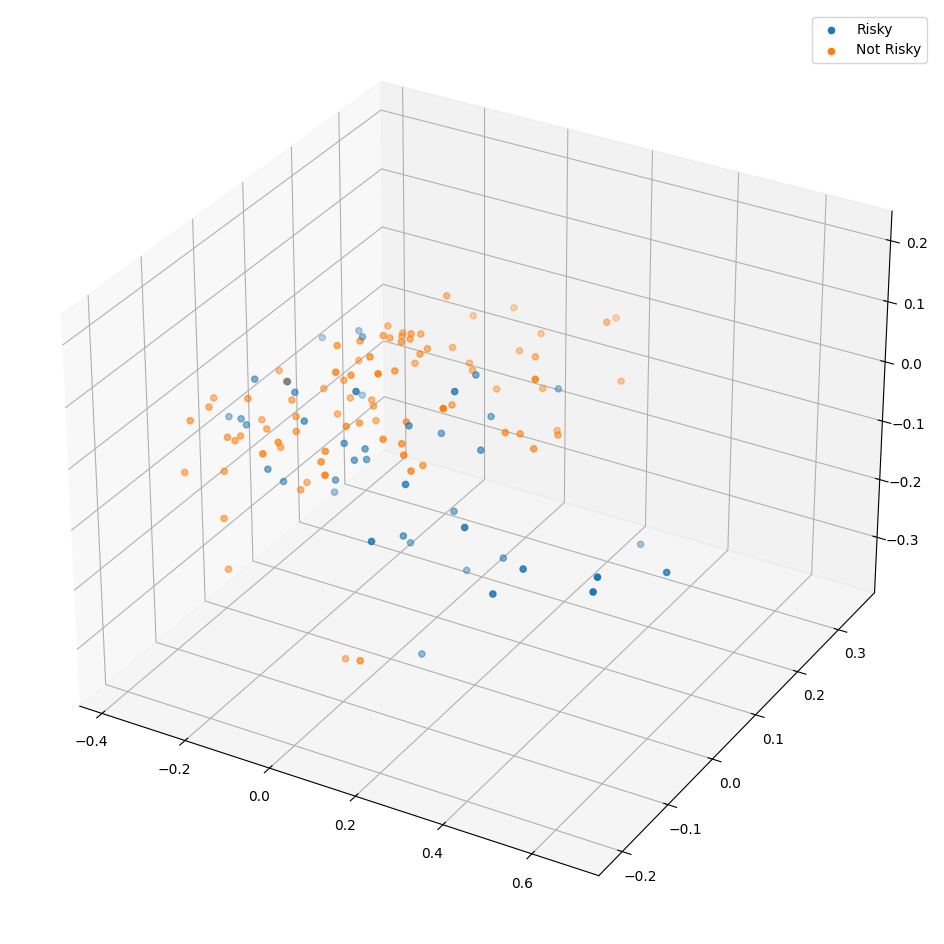

In [1233]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=3) 
pca_transform = pca.fit_transform(feature_matrix.values)

print(sum(pca.explained_variance_ratio_))
pc_df = pd.DataFrame(pca_transform,columns=['PC1','PC2','PC3'])
pc_df.index = feature_matrix.index 

w_risk_feat = pd.concat(
    (
        feature_matrix, 
        pc_df,
        w_geom_zip[['geometry','disaster_prone?']]
    ),
    axis=1
)

w_risk_feat = w_risk_feat.dropna()

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')

risky=w_risk_feat.loc[w_risk_feat['disaster_prone?']]
ax.scatter(
    risky['PC1'], 
    risky['PC2'],
    risky['PC3'], 
    label='Risky'
)
not_risky=w_risk_feat.loc[~w_risk_feat['disaster_prone?']]
ax.scatter(
    not_risky['PC1'], 
    not_risky['PC2'],
    not_risky['PC3'], 
    label='Not Risky'
)
ax.legend()


In [1280]:
w_risk_feat#.drop(columns=['geometry']).groupby(['disaster_prone?']).mean().T

,1,2,3,4,5,6,singleStatusTotalReturns,marriedStatusTotalReturns,HoHTotalReturns,volunteerAssistedReturns,...,returnsTotalPersonalPropertyTax,returnsTotalMortgageInterestPaid,returnsDependentCareCredit,returnsEducationCredit,returnsPremiumsCredit,PC1,PC2,PC3,geometry,disaster_prone?
zip,,,,,,,,,,,,,,,,,,,,,
33510,0.302231,0.290061,0.162948,0.094659,0.121704,0.028398,0.510480,0.269777,0.194050,0.005409,...,0.012170,0.029074,0.245436,0.050710,0.104801,-0.183980,0.028281,0.004209,"MULTIPOLYGON (((-82.27168 27.93941, -82.27327 ...",False
33511,0.277235,0.273254,0.165400,0.099529,0.142237,0.042345,0.513934,0.288455,0.168295,0.005791,...,0.013391,0.035831,0.249729,0.054289,0.094463,-0.143667,0.047876,-0.016238,"POLYGON ((-82.27481 27.8591, -82.275 27.8593, ...",False
33523,0.338010,0.280612,0.147959,0.080357,0.113520,0.039541,0.448980,0.335459,0.193878,0.007653,...,0.005102,0.029337,0.261480,0.031888,0.080357,-0.128121,0.061123,0.079666,"POLYGON ((-82.19991 28.36552, -82.1999 28.3654...",True
33525,0.292242,0.252922,0.147715,0.100956,0.150903,0.055260,0.441020,0.394261,0.139214,0.015940,...,0.011690,0.038257,0.235919,0.038257,0.072264,0.015598,0.053624,0.084281,"POLYGON ((-82.14275 28.28454, -82.14311 28.284...",False
33527,0.346561,0.250000,0.126984,0.083333,0.138889,0.054233,0.447090,0.373016,0.160053,0.000000,...,0.013228,0.042328,0.289683,0.039683,0.067460,-0.108561,0.128056,0.047506,"MULTIPOLYGON (((-82.25728 27.96933, -82.25846 ...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34689,0.283560,0.215686,0.148567,0.097285,0.180995,0.073906,0.502262,0.365008,0.106335,0.003771,...,0.013575,0.050528,0.182504,0.036199,0.091252,0.100744,-0.046260,0.049139,"POLYGON ((-82.78896 28.17228, -82.78891 28.172...",True
34690,0.360825,0.331370,0.166421,0.073638,0.060383,0.007364,0.553756,0.237113,0.181149,0.025037,...,0.005891,0.011782,0.213549,0.035346,0.128130,-0.252160,-0.066421,0.035500,"POLYGON ((-82.71899 28.20869, -82.7188 28.2086...",False
34691,0.354373,0.305681,0.157800,0.078449,0.086564,0.017133,0.519387,0.271416,0.177638,0.019838,...,0.007214,0.018936,0.219116,0.036970,0.113616,-0.189739,-0.039224,0.058085,"POLYGON ((-82.7424 28.21232, -82.7424 28.21218...",True


#### (4) Target Variable: Real Estate Prices

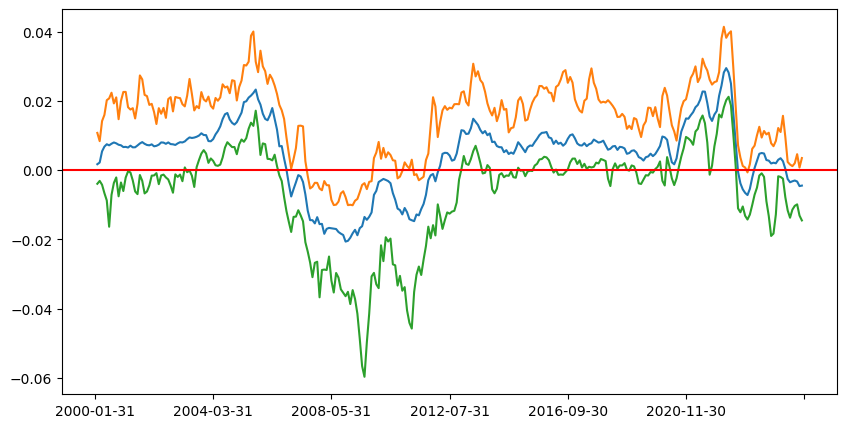

zip,33647,33511,33578,33612,33615,34668,33610,33617,33614,34609,...,33548,34607,33767,33762,33715,33785,33576,33786,34661,34681
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,NaN,0.004575,-0.000094,0.003897,0.003665,0.001556,0.003666,0.002741,0.002468,0.002571,...,0.004733,0.002051,0.001527,-0.000779,0.001396,0.002037,0.000957,0.002201,NaN,0.000018
2000-03-31,NaN,0.003472,-0.000355,0.004748,0.002875,0.002000,0.003916,0.002125,0.004152,0.003291,...,0.007608,0.002207,0.003067,0.000462,0.001923,0.003013,0.000329,0.006217,NaN,0.000614
2000-04-30,NaN,0.006869,-0.000171,0.010514,0.006388,0.003879,0.004458,0.003342,0.007866,0.004733,...,0.011663,0.005092,0.009269,0.002905,0.005927,0.009063,0.001825,0.011828,NaN,0.003462
2000-05-31,NaN,0.002507,-0.002322,0.010131,0.004548,0.004591,0.000981,0.002617,0.007080,0.004458,...,0.009340,0.004730,0.013654,0.006592,0.009606,0.012377,0.002555,0.015771,NaN,0.009179


In [1255]:
ts=homeprices.set_index('zip').drop(columns=['Metro','CountyName']).T#.diff()
ts_roc = ts.diff().div(ts)
ts_roc.mean(axis=1).plot(figsize=(10,5))
ts_roc.max(axis=1).plot(figsize=(10,5))
ts_roc.min(axis=1).plot(figsize=(10,5))

plt.axhline(0,color='red')
plt.show()

ts_roc.head(5)

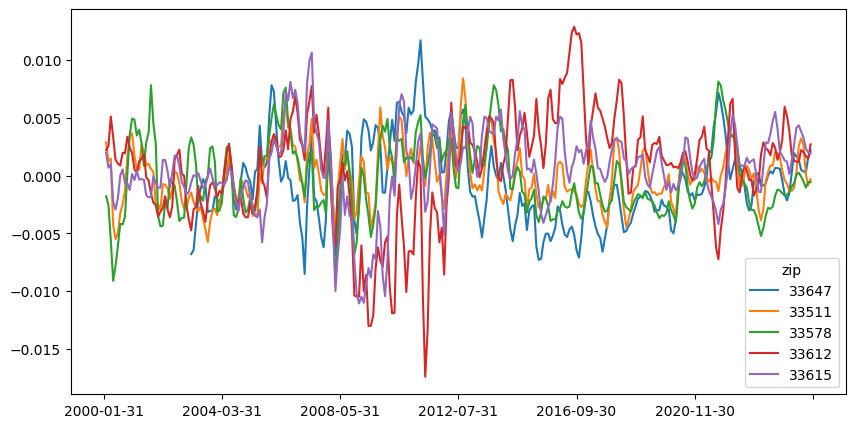

In [1168]:
mean_diff_by_qtr = ts_roc.sub(ts_roc.mean(axis=1),axis=0)
mean_diff_by_qtr.iloc[:,:5].plot(figsize=(10,5))

plt.show()

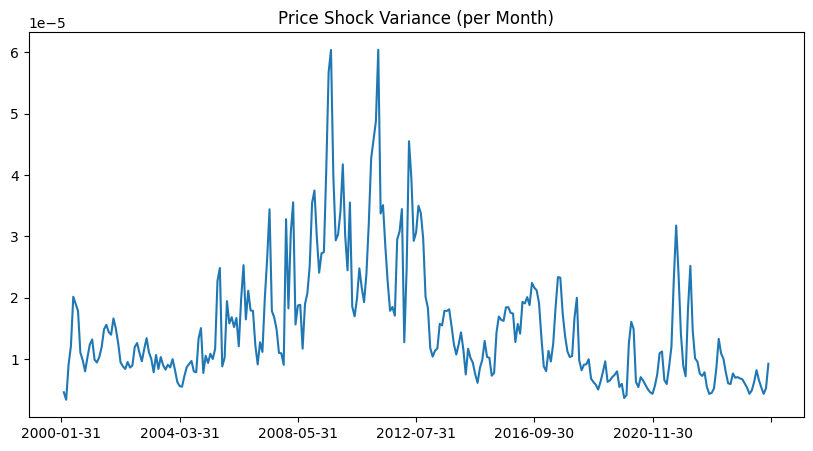

In [1267]:
######hopefully variance remains stable...

mean_diff_by_qtr.var(axis=1).plot(figsize=(10,5), title='Price Shock Variance (per Month)')
plt.show()

In [1195]:
rm_nulls = mean_diff_by_qtr.dropna()

alpha=0.05 # how much should we discount historical observations into the index?
N = len(rm_nulls)
w = np.array([(1-alpha)**i for i in range(N)][::-1]) 
w_norm = w/w.sum() 
w_norm

target_var = (rm_nulls.T@w_norm)*1e3
w_risk_feat['home_price_shift_index'] = target_var

w_risk_feat.groupby(['disaster_prone?'])[['home_price_shift_index']].mean()

,home_price_shift_index
disaster_prone?,
False,0.101482
True,-0.210301


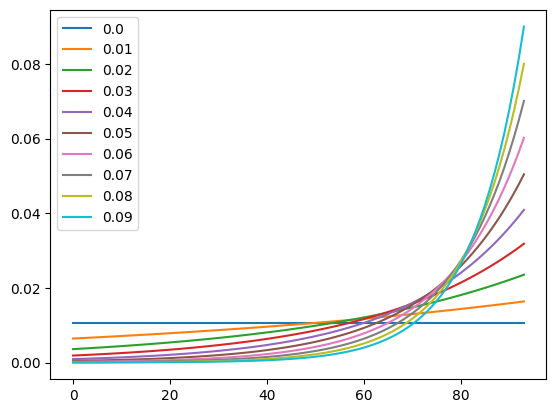

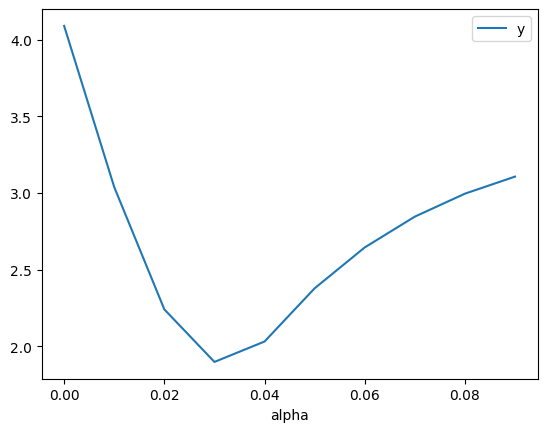

In [1197]:
def weight_func(df, alpha):
    N=len(df)
    w = np.array([(1-alpha)**i for i in range(N)][::-1]) 
    w_norm = w/w.sum() 
    return w_norm

fig,ax=plt.subplots()
alphas = np.arange(0.00,0.1,0.01)
for alpha in alphas:
    ax.plot(weight_func(rm_nulls,alpha),label=alpha)
plt.legend()
plt.show()

d=[]
for alpha in alphas: 
    w_norm = weight_func(rm_nulls,alpha)
    y = (rm_nulls.T@w_norm)*1e3
    d.append([alpha,y.max()])
    pass 

pd.DataFrame(d, columns=['alpha','y']).set_index('alpha').plot()
plt.show()

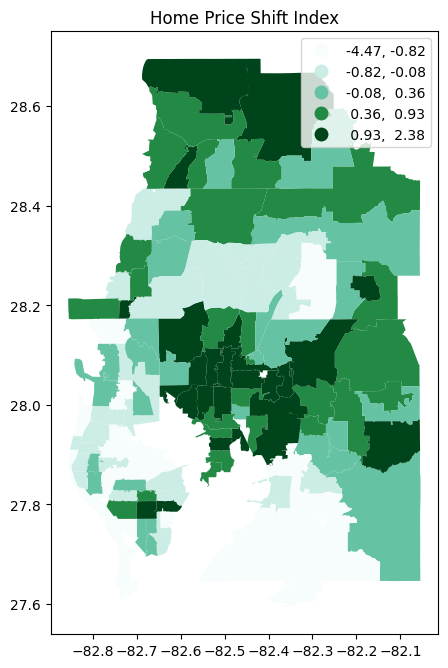

In [1209]:
gpd.GeoDataFrame(w_risk_feat).plot(
         column='home_price_shift_index', 
         legend=True, 
         markersize=0.01,
         figsize=(5,8),
         scheme='Quantiles', 
         legend_kwds={'loc': 'upper right'},
         cmap='BuGn',
)
plt.title('Home Price Shift Index')
plt.show()

#### (5) Matching 

Via the Mahalanobis Distance between the risky and non-risky groups 

See Jung et. al. (https://www.mdpi.com/2071-1050/10/11/4008) and King et. al. (https://gking.harvard.edu/files/gking/files/pan1900011_rev.pdf)

Note, while propensity scoring can be a way to explain the global treatment effect, it is not recommended for doing match-based experiments/studies. Propensity scores assume a fully randomized experiment acc. to King et. al., as the assumption of treatment onto each data sample is probabilistic, despite the nature of treatment/risk being a fully empirical measure in this case (flood risk). In other words, the propensity score method assumes each zip-code has a randomized chance of risk, and can thus be placed into treatment/control groups at will (which is not the case for a more "deterministic" assignment such as this, which functions more as an observational study versus a completely randomized controlled experiment). Jung et. al. justifies the usage of Mahalanobis distance-based matching to pair empirically-determined risk groups (floodzone, out-of-floodzone) based on their covariates. 



#### (6) Propensity Scoring 

127


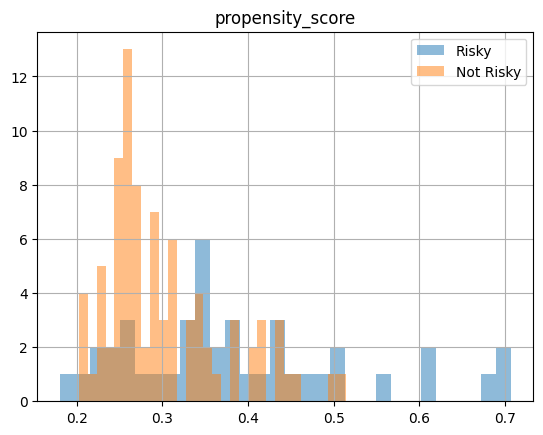

127
127
AVERAGE TREATMENT EFFECT: 0.07501814354721506


In [1205]:
from sklearn.linear_model import LogisticRegression, LinearRegression
import warnings
warnings.filterwarnings('ignore')

lr = LogisticRegression() 
print(len(feature_matrix))

X = w_risk_feat.iloc[:,:-5].values
T = w_risk_feat['disaster_prone?'].to_numpy().reshape(-1,1)
Y = StandardScaler().fit_transform(w_risk_feat['home_price_shift_index'].to_numpy().reshape(-1,1))

lr.fit(X,T)

w_risk_feat['propensity_score'] = lr.predict_proba(X)[:,1] 
w_risk_feat.head(5)

fig,ax=plt.subplots()

w_risk_feat.loc[w_risk_feat['disaster_prone?']][['propensity_score']].hist(bins=30, label='Risky', alpha=0.5, ax=ax)
w_risk_feat.loc[~w_risk_feat['disaster_prone?']][['propensity_score']].hist(bins=30, label='Not Risky', alpha=0.5, ax=ax)
plt.legend()
plt.show()

base_model = LinearRegression() 
X_b = w_risk_feat[['propensity_score','disaster_prone?']].values
print(len(X_b))
print(len(Y))
base_model.fit(X_b,Y) 

ATE = base_model.coef_[0][-1]

print(f'AVERAGE TREATMENT EFFECT: {ATE}')

In [1207]:
base_model.coef_

array([[-3.94214017,  0.07501814]])

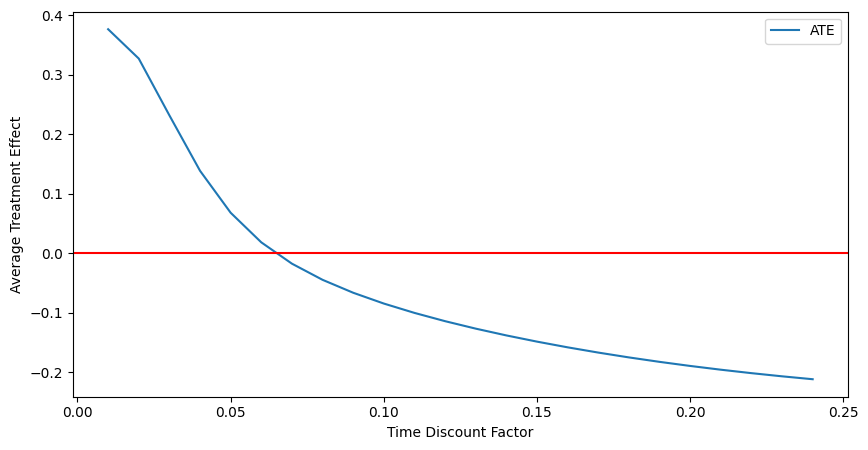

In [1211]:
def generate_price_index(home_prices, zips, alpha=0.05, plot=False): 
    
    mean_diff_by_qtr = home_prices[zips].sub(home_prices.mean(axis=1),axis=0)
    
    rm_nulls = mean_diff_by_qtr.dropna()#.fillna(method='ffill')

    N = len(rm_nulls)
    w = np.array([(1-alpha)**i for i in range(N)][::-1]) 
    w_norm = w/w.sum() 

    target_var = (rm_nulls.T@w_norm)*1e3
    st_target = StandardScaler().fit_transform(target_var.to_numpy().reshape(-1,1))
        

    return st_target

def calculate_propensity_score(X,T):

    lr = LogisticRegression() 
    lr.fit(X,T)
    p_scores = lr.predict_proba(X)[:,1] 

    return p_scores

def estimate_treatment_effect(p_scores, T, Y):

    base_model = LinearRegression() 
    X_b = np.c_[T, p_scores]

    base_model.fit(X_b, Y) 

    ATE = base_model.coef_[0][0]
    
    return ATE
    

X = feature_matrix.values
zips = feature_matrix.index

T = w_risk_feat['disaster_prone?'].to_numpy().reshape(-1,1)
p_T = calculate_propensity_score(X,T) 

alphas = np.arange(0.01,0.25,0.01)

r = []
for alpha in alphas: 
    Y = generate_price_index(ts_roc, zips, alpha=alpha) 
    ATE = estimate_treatment_effect(p_T, T, Y)
    r.append([alpha, ATE]) 

r = pd.DataFrame(r, columns=['Time Discount Factor', 'ATE'])

r.set_index('Time Discount Factor').plot(figsize=(10,5))
plt.axhline(0.0,color='red')
plt.ylabel('Average Treatment Effect')
plt.show()

Doubly Robust Estimation